In [1]:
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
import sys

sys.path.insert(0, 'C:/Users/igorl/CMF/reporting-forecasting')
import plotly.graph_objects as go
import os
import matplotlib.pyplot as plt
from functions.read_table import read_table
from tqdm import tqdm


pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [2]:
train_dir = '../data/oil_gas_train/'

In [3]:
def load_data(dir):
    df = pd.concat([read_table(os.path.join(dir, file), file)
                    for file in tqdm(os.listdir(dir))])

    company_names = df['Company_name'].copy()
    df.columns = ['{}_{}'.format(col, i) for i, col in enumerate(df.columns)]
    df = df[df.columns[df.nunique(dropna=False) > 1]]
    df = df.apply(pd.to_numeric, errors='coerce')
    df.iloc[:, -1] = company_names
    return df


In [4]:
df = load_data(train_dir)

100%|██████████| 54/54 [00:09<00:00,  5.91it/s]


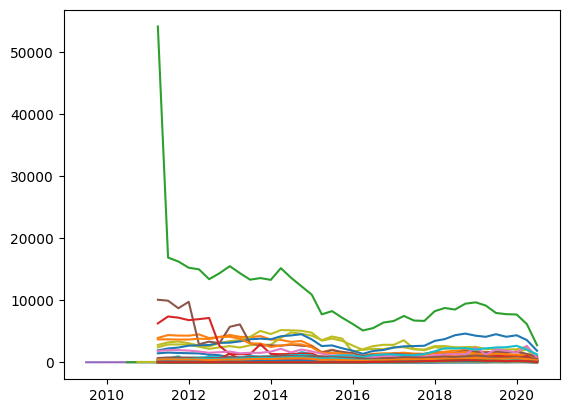

In [5]:
for company in df[df.columns[-1]].unique():
    plt.plot(
        df[df[df.columns[-1]] == company].index,
        df[df[df.columns[-1]] == company].Revenue_0.values, label=company)

plt.show()

Feature engineering 

In [6]:
df['month'] = pd.Series(df.index, dtype='datetime64[ns]').dt.month.values
df['month_sin'] = np.sin(2 * np.pi * df['month']/12.0)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12.0)

C:\Users\igorl\AppData\Local\Temp\ipykernel_21008\158446738.py:1: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  df['month'] = pd.Series(df.index, dtype='datetime64[ns]').dt.month.values


In [7]:
target_columns = ['Revenue_0', 'Operating Income_14']
feature_columns = df.columns.drop(target_columns+['Company_name_329'])

imp_mean = SimpleImputer(
    missing_values=np.nan,
    strategy='constant',
    fill_value=0,
).fit(df[feature_columns])

X = df[feature_columns]
y = df[target_columns]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

best_score = np.Inf
for model in [Ridge()]:#, CatBoostRegressor(silent=True), RandomForestRegressor(), Lasso(), LinearRegression(), ElasticNet()]:
    regr = MultiOutputRegressor(model)

    pipe = Pipeline([('imputer', imp_mean), ('regr', regr)])
    pipe.fit(X_train, y_train)
    if mean_squared_error(pipe.predict(X_test), y_test) < best_score:
        best_score = mean_squared_error(pipe.predict(X_test), y_test)
        best_model = model

In [8]:
print(best_score)
print(best_model)

3.5954387740219746
Ridge()


In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

for scaler in [StandardScaler(), MinMaxScaler()]:
    regr = MultiOutputRegressor(Ridge())
    pipe = Pipeline([('imputer', imp_mean), ('scaler', scaler), ('regr', regr)])
    pipe.fit(X_train, y_train)
    print('{} : {}'.format(scaler.__class__.__name__,
          mean_squared_error(pipe.predict(X_test), y_test)))


StandardScaler : 457.60182724852154
MinMaxScaler : 64662.06147301015


In [10]:
regr = MultiOutputRegressor(Ridge())
pipe = Pipeline([('imputer', imp_mean), ('regr', regr)])
pipe.fit(X_train, y_train)
print('Ridge : {}'.format(mean_squared_error(pipe.predict(X_test), y_test)))


Ridge : 3.5954387740219746


In [11]:
def train_vanilla_model(model, X_train, y_train, X_test, y_test):
    regr = MultiOutputRegressor(model)

    imp_mean = SimpleImputer(
        missing_values=np.nan,
        strategy='constant',
        fill_value=0,
    )

    pipe = Pipeline([('imputer', imp_mean), ('regr', regr)])
    pipe.fit(X_train, y_train)
    print('Ridge : {}'.format(mean_squared_error(pipe.predict(X_test), y_test)))
    return pipe

In [12]:
train_vanilla_model(Ridge(), X_train, y_train, X_test, y_test)

Ridge : 3.5954387740219746


Pipeline(steps=[('imputer', SimpleImputer(fill_value=0, strategy='constant')),
                ('regr', MultiOutputRegressor(estimator=Ridge()))])

Scaler не помог

Time series

Возьмем среднее значение за предыдущие периоды с помощью окна и добавим как фичу

In [13]:
df.index = pd.Series(df.index.astype('str').str[:10], dtype='datetime64[ns]')
df = df.sort_index()
df = df.loc['2011-03-31':, :]

Удалим все индексы вплоть до 9 для удобства кросс валидации (2010-12-31) так как по ним всего 2 компании

In [14]:
X = df[feature_columns]
y = df[target_columns]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

train_vanilla_model(Ridge(), X_train, y_train, X_test, y_test)

Ridge : 2.110024762961822


Pipeline(steps=[('imputer', SimpleImputer(fill_value=0, strategy='constant')),
                ('regr', MultiOutputRegressor(estimator=Ridge()))])

Видно что эти две данные давали половину ошибки.

In [15]:
def cross_vall_score(model):
    cv_scores = []
    for date in df.index.unique()[1:-1].values:
        X_train, X_test = df[feature_columns].loc[:
                                                  date], df[feature_columns].loc[date:date+1]
        y_train, y_test = df[target_columns].loc[:date], df[target_columns].loc[date:date+1]


        imp_mean = SimpleImputer(
            missing_values=np.nan,
            strategy='constant',
            fill_value=0,
        )

        pipe = Pipeline([('imputer', imp_mean), ('regr', model)])
        pipe.fit(X_train, y_train)
        cv_scores.append(mean_squared_error(pipe.predict(X_test), y_test))

    return np.array(cv_scores).mean()

In [16]:
regr = MultiOutputRegressor(Ridge())
cross_vall_score(regr)

0.03987194556948717

Теперь обогатим нашу выьорку фичами за прошлый период

In [17]:
pd.options.mode.chained_assignment = None
model=MultiOutputRegressor(Ridge())

cv_scores = []

short_list = feature_columns.to_list()
short_list.append('rev_prev')

for date in df.index.unique()[1:-1].values:
    X_train, X_test = df.loc[:date].copy(), df.loc[date:date+1].copy()
    y_train, y_test = df[target_columns].loc[:
                                             date], df[target_columns].loc[date:date+1]

    rev_prev = X_train.groupby('Company_name_329')['Revenue_0'].mean()

    X_train.loc[:, 'rev_prev'] = 0
    X_test.loc[:, 'rev_prev'] = 0
    for c in X_train['Company_name_329']:
        X_train[X_train['Company_name_329'] ==
                c]['rev_prev'] = rev_prev[c]
        X_test[X_test['Company_name_329'] ==
                c]['rev_prev'] = rev_prev[c]
    X_train = X_train[short_list]
    X_test = X_test[short_list]

    imp_mean = SimpleImputer(
        missing_values=np.nan,
        strategy='constant',
        fill_value=0,
    )

    pipe = Pipeline([('imputer', imp_mean), ('regr', regr)])
    pipe.fit(X_train, y_train)

    cv_scores.append(mean_squared_error(pipe.predict(X_test), y_test))

np.array(cv_scores).mean()

0.039871945557936536

Grid search 

In [21]:
from sklearn.model_selection import GridSearchCV

data_indices = []
params = {'regr__estimator__alpha': [0.5, 0.6, 0.7, 0.8, 1]}

for date in df.index.unique()[1:-1].values:
    test_idx = df.reset_index()[(df.reset_index()['index'] >= date) & (df.reset_index()[
        'index'] < date + 1)].index
    data_indices.append((df[feature_columns].loc[:date].reset_index(
        drop=True).index, test_idx))

imp_mean = SimpleImputer(
    missing_values=np.nan,
    strategy='constant',
    fill_value=0,
)

regr = MultiOutputRegressor(Ridge())
pipe = Pipeline([('imputer', imp_mean), ('regr', regr)])
reg = GridSearchCV(pipe, params, cv=data_indices,
                   scoring='neg_mean_squared_error')
reg.fit(df[feature_columns].reset_index(drop=True),
        df[target_columns].reset_index(drop=True))
print(reg.best_params_)
print(reg.best_score_)

{'regr__estimator__alpha': 0.7}
-0.03986544934626929


In [22]:
regr = MultiOutputRegressor(Ridge(alpha=1.2))
pipe = Pipeline([('imputer', imp_mean), ('regr', regr)])

cross_val_score(pipe, df[feature_columns].reset_index(drop=True),
                df[target_columns].reset_index(drop=True), cv=data_indices, scoring='neg_mean_squared_error').mean()

-0.039879796933992274

In [23]:
regr = MultiOutputRegressor(Ridge(alpha=1.2))
pipe = Pipeline([('imputer', imp_mean), ('regr', regr)])

cross_vall_score(pipe)

0.039879796933992274

Протестируем модель на тестовой выборке

In [24]:
test_dir = '../data/oil_gas_train_test/'

test_df = load_data(test_dir)
test_df.index = pd.Series(test_df.index.astype(
    'str').str[:10], dtype='datetime64[ns]')

test_df = test_df[test_df.index > '2020-06-30']

100%|██████████| 52/52 [00:09<00:00,  5.66it/s]


In [25]:
X = df[feature_columns]
y = df[target_columns]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

pipe = train_vanilla_model(Ridge(), X_train, y_train, X_test, y_test)

Ridge : 2.110024762961822


In [26]:
test_df['month'] = pd.Series(
    test_df.index, dtype='datetime64[ns]').dt.month.values
test_df['month_sin'] = np.sin(2 * np.pi * test_df['month']/12.0)
test_df['month_cos'] = np.cos(2 * np.pi * test_df['month']/12.0)


In [27]:
mean_squared_error(pipe.predict(test_df[feature_columns]), test_df[target_columns])

94.76363578264375

In [30]:
from prophet import Prophet

In [57]:
def df_to_prophet(x, y):
    data = x.copy()
    data['y'] = y['Revenue_0'].copy()
    data = data.reset_index()
    data = data.rename(columns={'index': 'ds'})
    return data

15:45:14 - cmdstanpy - INFO - Chain [1] start processing
15:45:14 - cmdstanpy - INFO - Chain [1] done processing


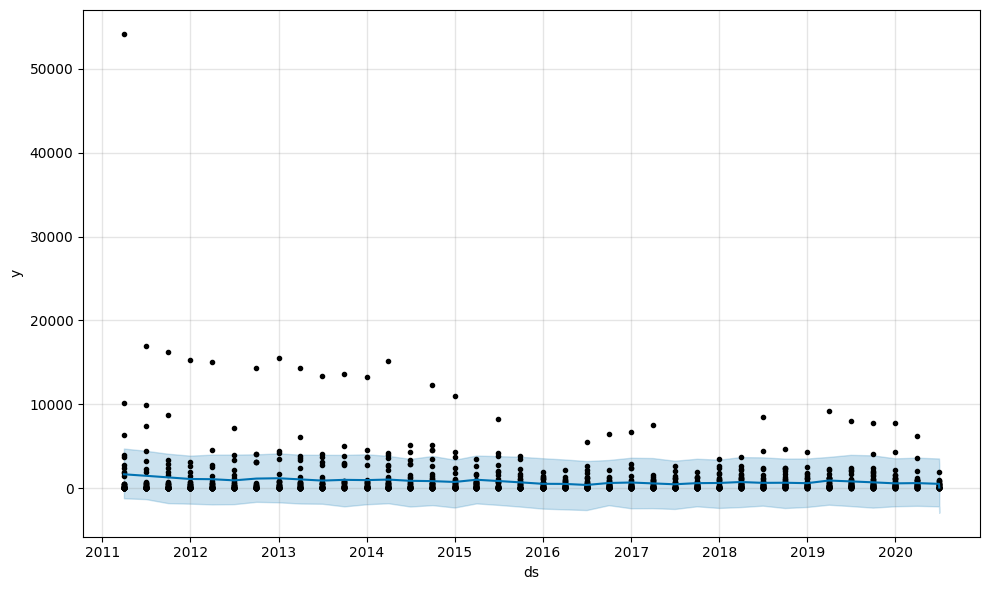

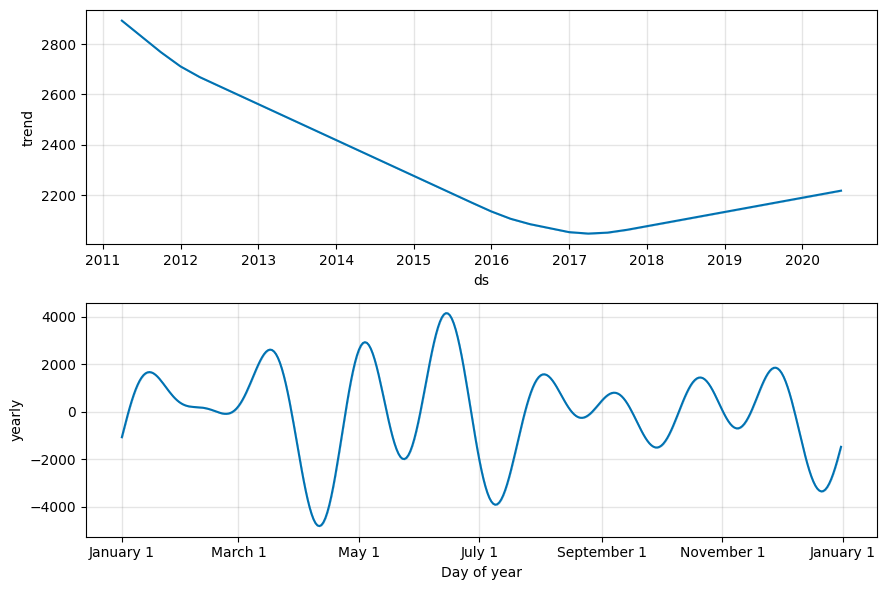

In [79]:
model_baseline = Prophet()
model_baseline.fit(df_to_prophet(X_train, y_train))
future_baseline = model_baseline.make_future_dataframe(periods=1)
forecast_baseline = model_baseline.predict(future_baseline)
model_baseline.plot(forecast_baseline)
model_baseline.plot_components(forecast_baseline)
print('')


In [91]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

performance_baseline = pd.merge(
    df_to_prophet(X_train, y_train), forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')

performance_baseline_MAE = mean_absolute_error(
    performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAE for the baseline model is {performance_baseline_MAE}')

performance_baseline_MAPE = mean_absolute_percentage_error(
    performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAPE for the baseline model is {performance_baseline_MAPE}')


The MAE for the baseline model is 653.4007158292799
The MAPE for the baseline model is 5.837975250702643e+16


17:56:11 - cmdstanpy - INFO - Chain [1] start processing
17:56:14 - cmdstanpy - INFO - Chain [1] done processing


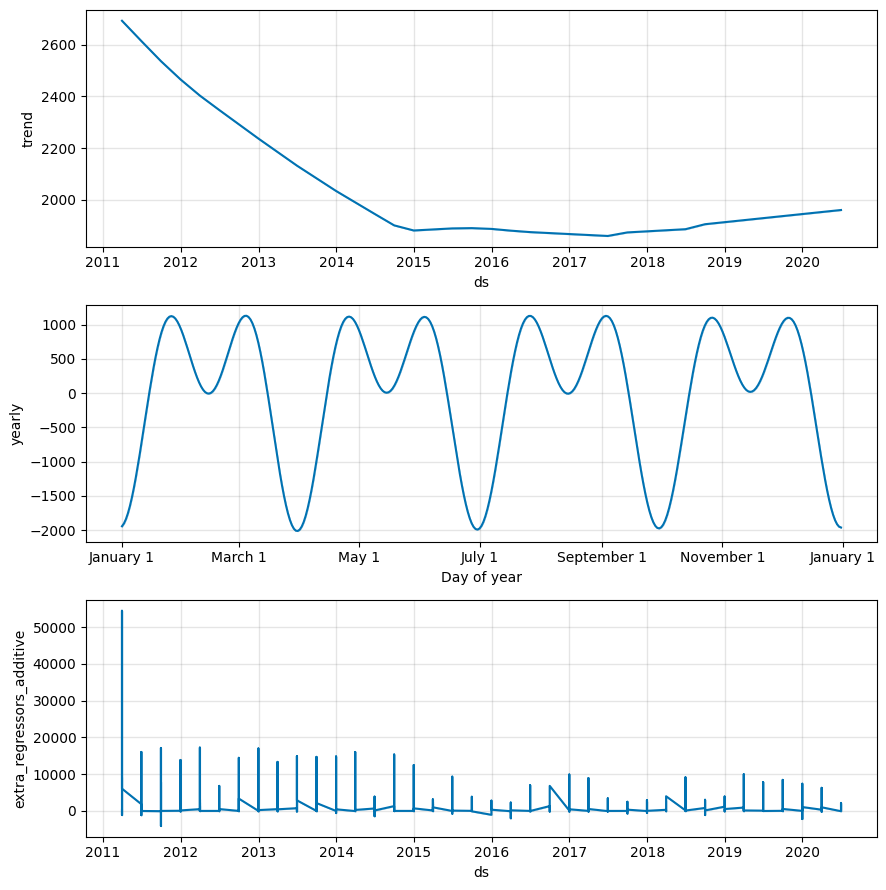

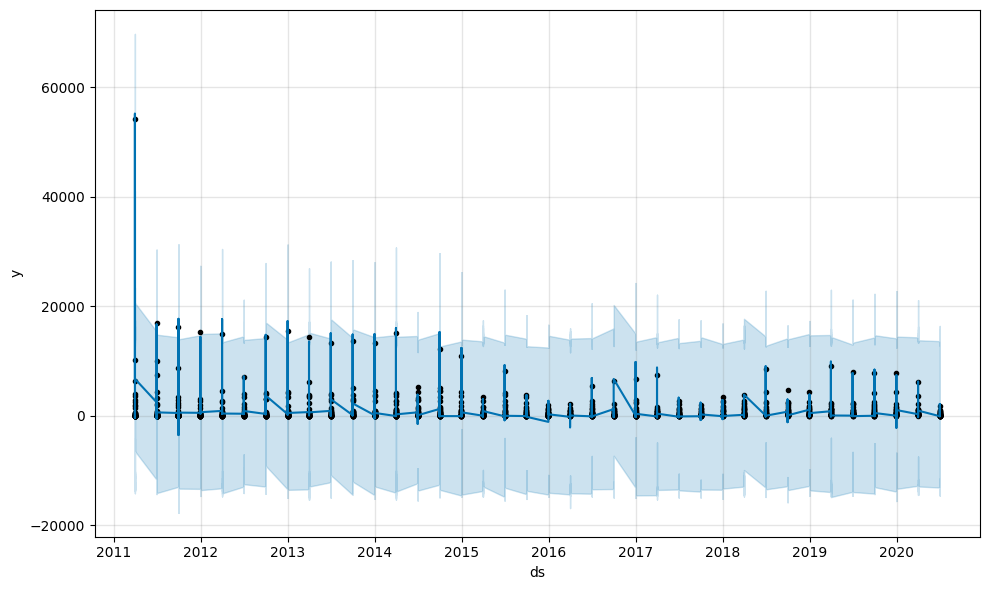

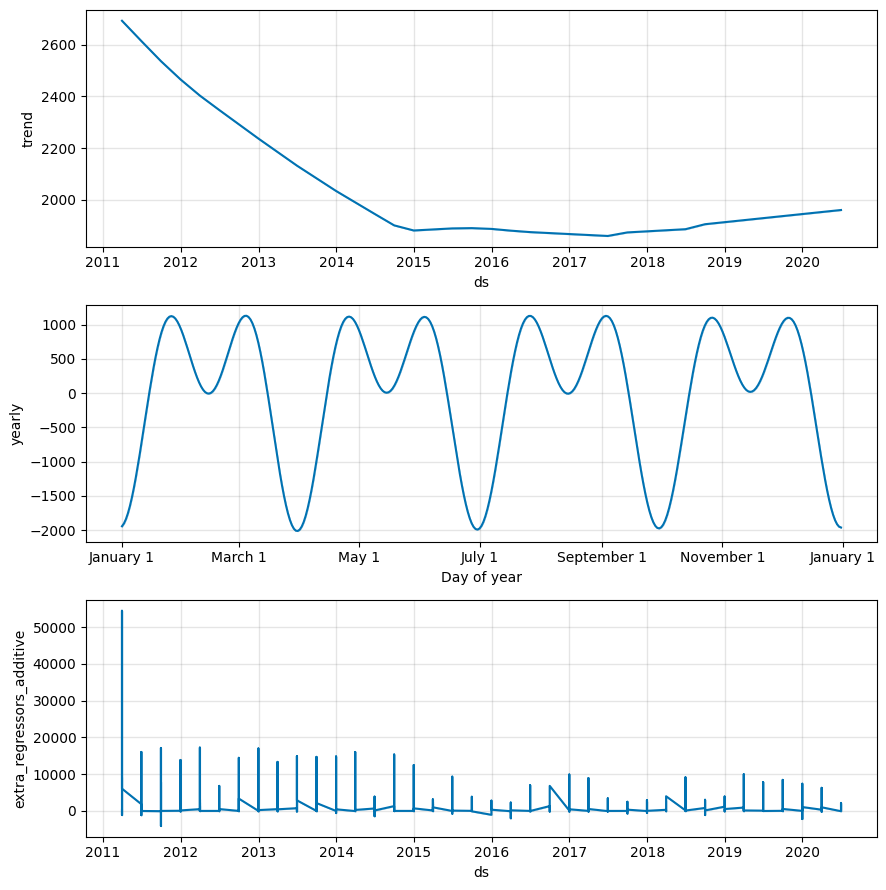

In [115]:
n = 50
model_multivariate = Prophet()
for col in feature_columns[:n]:
    model_multivariate.add_regressor(col, standardize=False)

model_multivariate.fit(df_to_prophet(X_train.fillna(0), y_train))

future_multivariate = model_multivariate.make_future_dataframe(periods=1)
future_multivariate = pd.merge(
    future_multivariate, df_to_prophet(X_train.fillna(0), y_train)[['ds'] + feature_columns[:n].to_list()], on='ds', how='inner')
future_multivariate = future_multivariate.fillna(method='ffill')

forecast_multivariate = model_multivariate.predict(future_multivariate)
model_multivariate.plot(forecast_multivariate)
print('')
model_multivariate.plot_components(forecast_multivariate)


In [117]:
performance_multivariate = pd.merge(
    df_to_prophet(X_train, y_train),
    forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

performance_multivariate_MAE = mean_absolute_error(
    performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAE for the multivariate model is {performance_multivariate_MAE}')

performance_multivariate_MAPE = mean_absolute_percentage_error(
    performance_multivariate['y'], performance_multivariate['yhat'])
print(
    f'The MAPE for the multivariate model is {performance_multivariate_MAPE}')


The MAE for the multivariate model is 1298.5605406321945
The MAPE for the multivariate model is 5.833723667382743e+17
